<a href="https://colab.research.google.com/github/kridtapon/Equal-Highs-Lows-Sweep-Reversal/blob/main/Equal_Highs_Lows_Sweep_%2B_Reversal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.8 MB/s eta 0:00:00


In [ ]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Download historical data
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# STEP 1: Identify potential equal lows (within a small threshold, e.g., 0.1%)
threshold = 0.001
df['Equal_Low'] = df['Low'].rolling(5).apply(
    lambda x: any(abs(x[-1] - x[:-1]) / x[-1] < threshold), raw=True
)

# STEP 2: Detect liquidity sweeps (price wicks below recent equal lows)
df['Liquidity_Sweep'] = (df['Low'] < df['Low'].shift(1)) & (df['Equal_Low'].shift(1).fillna(False))

# Filter for backtest period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# STEP 3: Entry condition: after a sweep, strong bullish reversal (Close > Open)
df['Entry'] = df['Liquidity_Sweep'] & (df['Close'] > df['Open'])

# STEP 4: Simulate exit: 5% profit or 1% stop loss from entry price
entry_price = df['Close'].where(df['Entry']).ffill()
df['Exit'] = (df['Close'] >= entry_price * 1.05) | (df['Close'] <= entry_price * 0.95)

# Run backtest
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Output stats and plot
print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           201947.376008
Total Return [%]                       101.947376
Benchmark Return [%]                   180.172878
Max Gross Exposure [%]                      100.0
Total Fees Paid                       5460.583948
Max Drawdown [%]                        12.610027
Max Drawdown Duration           330 days 00:00:00
Total Trades                                   21
Total Closed Trades                            20
Total Open Trades                               1
Open Trade PnL                       -5553.245122
Win Rate [%]                                 75.0
Best Trade [%]                          22.567459
Worst Trade [%]                         -7.354986
Avg Winning Trade [%]                     7.42471
Avg Losing Trade [%]                    -6.426916


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
Optimizing...: 2700it [04:53,  9.21it/s]



🏆 Best Parameters:
Shift: 3, Win: 1.1, Loss: 0.9
Total Return: 163.03%


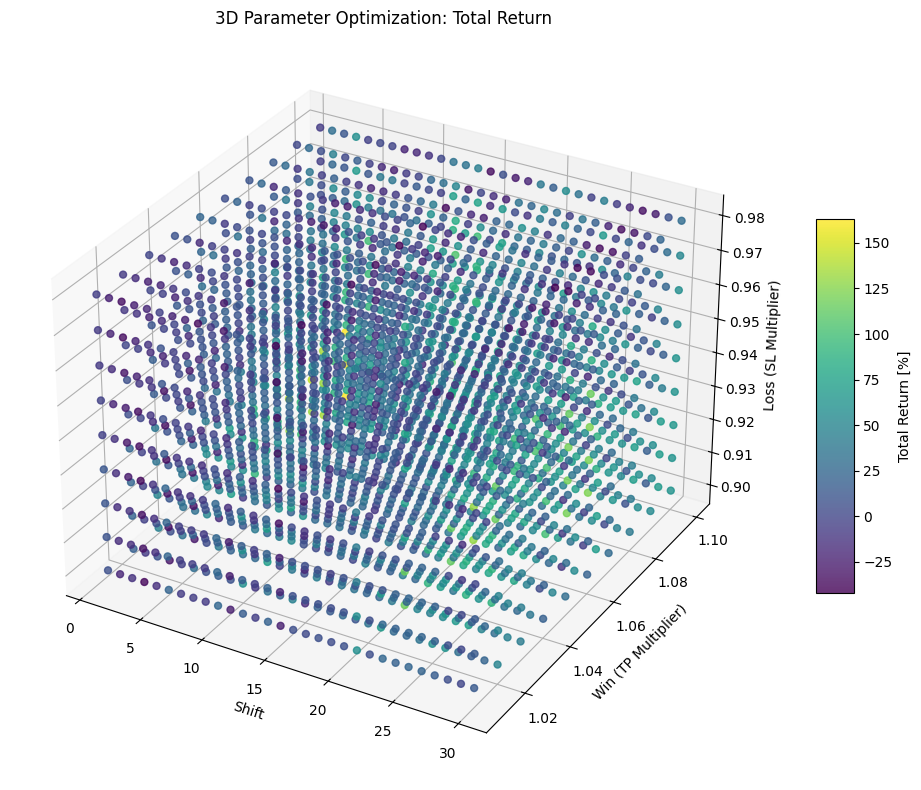

Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                   263028.74765
Total Return [%]                              163.028748
Benchmark Return [%]                          114.263761
Max Gross Exposure [%]                             100.0
Total Fees Paid                              4352.696902
Max Drawdown [%]                               18.891168
Max Drawdown Duration                  207 days 00:00:00
Total Trades                                          14
Total Closed Trades                                   14
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   92.857143
Best Trade [%]                                 17.691941
Worst Trade [%]                

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product
from tqdm import tqdm  # optional, for progress bar
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Download historical data
symbol = 'IBM'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# STEP 1: Identify potential equal lows (within a small threshold, e.g., 0.1%)
threshold = 0.001
df['Equal_Low'] = df['Low'].rolling(5).apply(
    lambda x: any(abs(x[-1] - x[:-1]) / x[-1] < threshold), raw=True
)

# Filter for backtest period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Parameter grid
shift_range = range(1, 31)
win_range = np.round(np.arange(1.01, 1.10, 0.01), 2)
loss_range = np.round(np.arange(0.90, 0.99, 0.01), 2)

results = []

# Loop through all parameter combinations
for shift, win, loss in tqdm(product(shift_range, win_range, loss_range), desc="Optimizing..."):
    temp_df = df.copy()

    # Liquidity Sweep logic with shift
    temp_df['Liquidity_Sweep'] = (temp_df['Low'] < temp_df['Low'].shift(shift)) & \
                                 (temp_df['Equal_Low'].shift(shift).fillna(False))

    # Entry after sweep + bullish candle
    temp_df['Entry'] = temp_df['Liquidity_Sweep'] & (temp_df['Close'] > temp_df['Open'])

    # Simulate entry price and exit condition
    entry_price = temp_df['Close'].where(temp_df['Entry']).ffill()
    temp_df['Exit'] = (temp_df['Close'] >= entry_price * win) | \
                      (temp_df['Close'] <= entry_price * loss)

    # Build portfolio
    try:
        pf = vbt.Portfolio.from_signals(
            close=temp_df['Close'],
            entries=temp_df['Entry'],
            exits=temp_df['Exit'],
            init_cash=100_000,
            fees=0.001,
            slippage=0.002,
            freq='D',
        )

        stats = pf.stats()
        total_return = stats.loc['Total Return [%]']
        results.append({'shift': shift, 'win': win, 'loss': loss, 'return': total_return, 'pf': pf})
    except Exception as e:
        continue  # skip if backtest fails

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find best configuration
best_row = results_df.sort_values('return', ascending=False).iloc[0]
print("\n Best Parameters:")
print(f"Shift: {best_row['shift']}, Win: {best_row['win']}, Loss: {best_row['loss']}")
print(f"Total Return: {best_row['return']:.2f}%")

# Create 3D scatter plot of optimization results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(
    results_df['shift'],
    results_df['win'],
    results_df['loss'],
    c=results_df['return'],
    cmap='viridis',
    s=25,
    alpha=0.8
)

# Axis labels
ax.set_xlabel('Shift')
ax.set_ylabel('Win (TP Multiplier)')
ax.set_zlabel('Loss (SL Multiplier)')
ax.set_title('3D Parameter Optimization: Total Return')

# Color bar for return
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Total Return [%]')

plt.tight_layout()
plt.show()

# Plot the best portfolio
best_row['pf'].plot().show()
print(best_row['pf'].stats())


[*********************100%***********************]  1 of 1 completed
<ipython-input-7-a8e604a8f614>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-a8e604a8f614>:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



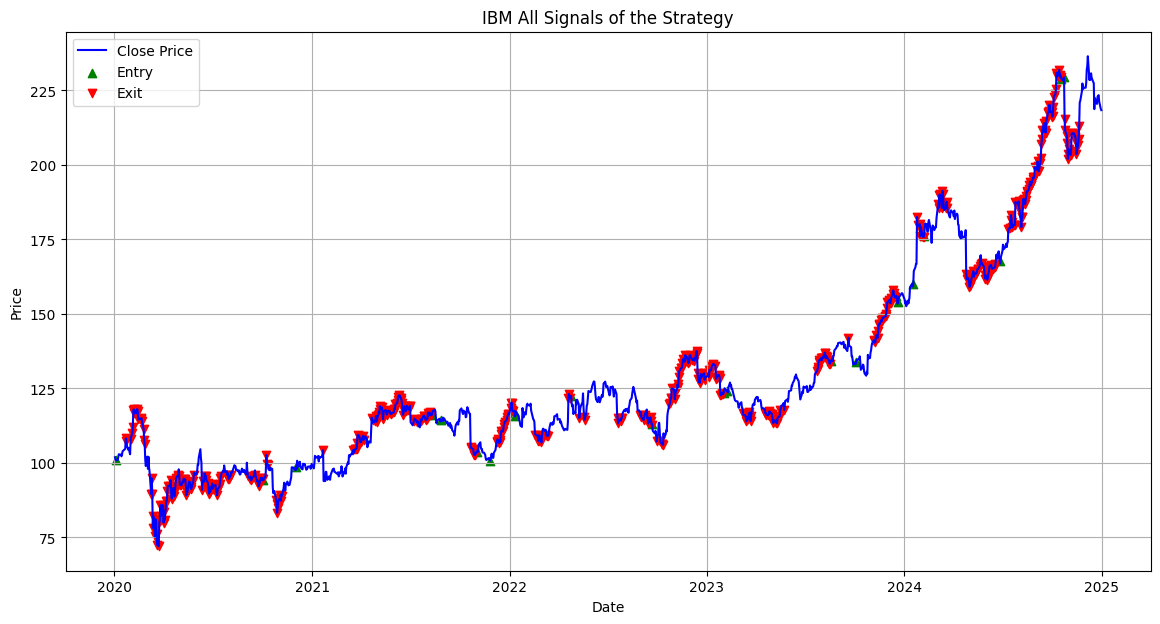

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download historical data
symbol = 'IBM'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# STEP 1: Identify potential equal lows (within a small threshold, e.g., 0.1%)
threshold = 0.001
df['Equal_Low'] = df['Low'].rolling(5).apply(
    lambda x: any(abs(x[-1] - x[:-1]) / x[-1] < threshold), raw=True
)

# STEP 2: Detect liquidity sweeps (price wicks below recent equal lows)
df['Liquidity_Sweep'] = (df['Low'] < df['Low'].shift(1)) & (df['Equal_Low'].shift(1).fillna(False))

# Filter for backtest period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# STEP 3: Entry condition: after a sweep, strong bullish reversal (Close > Open)
df['Entry'] = df['Liquidity_Sweep'] & (df['Close'] > df['Open'])

# STEP 4: Simulate exit: 5% profit or 1% stop loss from entry price
entry_price = df['Close'].where(df['Entry']).ffill()
df['Exit'] = (df['Close'] >= entry_price * 1.05) | (df['Close'] <= entry_price * 0.95)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')

# Mark entries
entry_points = df[df['Entry']]
plt.scatter(entry_points.index, entry_points['Close'], marker='^', color='green', label='Entry', alpha=1)

# Mark exits
exit_points = df[df['Exit']]
plt.scatter(exit_points.index, exit_points['Close'], marker='v', color='red', label='Exit', alpha=1)

plt.title(f'{symbol} All Signals of the Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.grid(True)
plt.show()
